The following code is part of "SymbXRL: Symbolic Explainable Deep Reinforcement Learning for Mobile Networks" 

Copyright - RESILIENT AI NETWORK LAB, IMDEA NETWORKS

DISCLAIMER: THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.

【版权声明】

【SYMBXRL项目的主执行文件，集成了SAC智能体和动作引导(Action Steering)功能】
【在原来的基础上新增两个测试，对数据作进一步分析】

# IMPORTS【导包】

In [2]:
# 导入系统路径设置
import sys
sys.path.insert(0, '../../')  # 添加项目根目录到Python路径

# 导入基础数据处理和可视化库
import numpy as np
import gymnasium as gym
import h5py
import plotly.graph_objects as go  # 交互式绘图库
from plotly.subplots import make_subplots  # 创建子图
import pandas as pd
import matplotlib.pyplot as plt  # 静态绘图库

# SAC算法相关导入
from constants import PROJ_ADDR  # 项目地址常量
sys.path.insert(0, '../')
from SAC.sac import SAC  # Soft Actor-Critic算法实现
from SAC.replay_memory import ReplayMemory  # 经验回放内存
from SAC.smartfunc import sel_ue  # 动作解码函数：将动作编号转换为用户选择
import torch  # PyTorch深度学习框架
from custom_mimo_env import MimoEnv, reverse_sel_ue  # Massive MIMO环境和动作编码函数

# Action Steering（动作引导）相关导入
from Action_Steering.action_steering_utils import (
    process_buffer,           # 处理数据缓冲区
    transform_action,         # 动作转换
    do_action_steering_this_timestep,  # 判断当前时间步是否执行动作引导
    extract_decision_from_suggested    # 从建议中提取决策
)
from Action_Steering.symbolic_representation import (
    QuantileManager,  # 分位数管理器：用于连续变量的离散化
    Symbolizer        # 符号化器：将数值状态转换为符号表示
)
from Action_Steering.experiment_constants import (
    KPI_LIST,  # 关键性能指标列表（如频谱效率、公平性等）
    USERS       # 用户配置信息
)
from Action_Steering.decision_graph import DecisionGraph  # 决策图：存储和学习状态-动作模式

In [3]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check CUDA version
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("Is CUDA available:", cuda_available)

# If CUDA is available, print the device name
if cuda_available:
    print("CUDA device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu124
CUDA version: 12.4
Is CUDA available: True
CUDA device name: NVIDIA A10


# ENVIRONMENT SETUP【初始化环境和SAC智能体】

In [4]:
# 加载数据集
# 打开HDF5格式的数据集文件，包含LOS（视距）高速场景的信道数据
H_file = h5py.File(f'{PROJ_ADDR}/A2-MIMOResourceScheduler/Datasets/LOS_highspeed2_64_7.hdf5','r')

# 从HDF5文件中获取信道矩阵H
# H是三维数组，包含多个时间步的信道状态信息
H = np.array(H_file.get('H'))

# 打印信道矩阵的形状
# 预期形状: (时间步数, 基站天线数, 用户数)
# 例如: (1000, 64, 7) 表示1000个时间步，64根基站天线，7个用户
print("H shape is:", H.shape)

# 从HDF5文件中获取最大频谱效率数据
# se_max_ur表示每个用户在理想条件下的最大可达频谱效率
se_max_ur = H_file.get('se_max')

# 将数据转换为NumPy数组以便处理
se_max_ur = np.array(se_max_ur)

# 打印最大频谱效率矩阵的形状
# 预期形状: (时间步数, 用户数)
# 例如: (1000, 7) 表示1000个时间步，每个时间步7个用户的最大频谱效率
print("se_max_ur shape is:", se_max_ur.shape)

H shape is: (1174, 64, 7)
se_max_ur shape is: (1174, 7)


In [5]:
# 创建Massive MIMO环境实例
# 参数: H - 信道矩阵, se_max_ur - 最大频谱效率数据
env = MimoEnv(H, se_max_ur)

# 定义SAC算法参数配置类
class SACArgs:
    def __init__(self):
        # 默认参数值
        self.policy = "Gaussian"  # 策略类型：高斯策略（随机策略），支持探索
        self.eval = False  # 模式选择：False=训练模式, True=评估模式
        self.gamma = 0.99  # 折扣因子：未来奖励的衰减系数，0.99表示重视长期回报
        self.tau = 0.005  # 目标网络平滑系数：控制目标网络更新速度，值越小更新越慢越稳定
        self.lr = 0.0003  # Critic网络学习率：值函数网络的学习速率
        self.alpha_lr = 0.0003  # Actor网络学习率：策略网络的学习速率
        self.alpha = 0.95  # 熵系数：平衡探索与利用，0.95表示强探索倾向
        self.automatic_entropy_tuning = True  # 自动熵调整：动态调整熵系数以优化探索
        self.seed = 1  # 随机种子：确保实验可重现
        self.batch_size = 256  # 批处理大小：每次从经验回放中采样的样本数
        self.max_episode_steps = len(H)  # 最大回合步数：等于数据集长度，使用完整数据作为一个回合
        self.max_episode = 85  # 最大训练回合数
        self.hidden_size = 512  # 隐藏层大小：神经网络隐藏层神经元数量
        self.updates_per_step = 1  # 每步更新次数：每个环境步执行多少次网络更新
        self.start_steps = 3000  # 初始探索步数：前3000步使用随机策略进行探索
        self.target_update_interval = 1  # 目标网络更新间隔：每个训练步都更新目标网络
        self.replay_size = 1000000  # 经验回放缓冲区大小：可存储100万个经验样本
        self.cuda = 1  # CUDA设备ID：使用第1个GPU
        self.gpu_nums = 1  # GPU数量：使用1个GPU

# 创建SACArgs参数配置实例
args = SACArgs()

# 设置随机种子以确保实验可重现
torch.manual_seed(args.seed)  # 设置PyTorch随机种子
np.random.seed(args.seed)  # 设置NumPy随机种子

# 获取环境的空间维度信息
num_states = env.observation_space.shape[0]  # 状态空间维度：21（7用户×3个特征）
num_actions = len([env.action_space.sample()])  # 动作空间维度：1（离散动作标量）
max_actions = env.action_space.n  # 最大动作数量：127（7个用户的所有非空组合）

# 初始化SAC智能体
# 参数说明：
# - num_states: 状态维度 = 21
# - num_actions: 动作维度 = 1  
# - max_actions: 最大动作数 = 127
# - args: 算法参数配置对象
# - args.lr: Critic学习率 = 0.0003
# - args.alpha_lr: Actor学习率 = 0.0003
agent = SAC(num_states, num_actions, max_actions, args, args.lr, args.alpha_lr)
print('SAC build finished')  # 输出SAC构建完成信息

# 加载预训练的SAC模型检查点
# 模型文件路径：项目地址下的预训练模型
ckpt_path = f"{PROJ_ADDR}/A2-MIMOResourceScheduler/models/SACG_884.53_551_dtLOS_HS2_checkpointed.pth_"
agent.load_checkpoint(ckpt_path)  # 从文件加载训练好的模型权重

# 初始化经验回放内存
# 参数：replay_size=1000000（缓冲区大小）, seed=1（随机种子）
memory = ReplayMemory(args.replay_size, args.seed)

SAC build finished
Loading models from /share/home/user018/SYMBXRL/A2-MIMOResourceScheduler/models/SACG_884.53_551_dtLOS_HS2_checkpointed.pth_


/share/home/user018/SYMBXRL/A2-MIMOResourceScheduler/SAC/../SAC/sac.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


# IMPLEMENTATION WITH AS【IAS参与控制】
【当IAS给出的建议可以获取更高的奖励，则替换掉当前智能体的决策】

In [38]:
# 初始化计数器：记录缓冲区适配的时间步
buffer_addpated_timestep = 0

# 初始化数据记录列表
step_rewards = []  # 存储每一步的奖励值
acn_str = []  # 存储动作策略信息
grp_str = []  # 存储分组策略信息
mean_rew = []  # 存储平均奖励值
fin_act = []  # 存储最终动作
score = 0  # 累计总奖励
state_data = []  # 存储状态数据
action_reward_data = []  # 存储动作-奖励数据
test_buffer = []  # 存储测试缓冲区数据

# 创建符号化器和分位数管理器对象
kpis = KPI_LIST  # 关键性能指标列表

# Action Steering配置
do_action_steering = True  # 是否启用动作引导【设置False，可以观测没有IAS，DRL自身的决策情况】
# do_action_steering = False
start_action_steering_from = 5  # 从第5步开始启用动作引导

# 符号化工具实例化
qunatile_manager = QuantileManager(kpis + ['scheduled_user'])  # 创建分位数管理器，管理KPI和调度用户的分位数
qunatile_manager.reset()  # 重置分位数管理器
qunatile_manager.partial_fit("scheduled_user", [0])  # 拟合最小调度用户数(0)
qunatile_manager.partial_fit("scheduled_user", [7])  # 拟合最大调度用户数(7)

# 定义符号化数据框
symbolic_df = pd.DataFrame()

# 创建符号化器实例
symbolizer = Symbolizer(quantile_manager=qunatile_manager, kpi_list=kpis, users=USERS)

# 实时决策图：为每个用户分组创建决策图
rt_decision_graph = {
    0: DecisionGraph(column_name="decision"),  # 分组0的决策图
    1: DecisionGraph(column_name="decision"),  # 分组1的决策图
    2: DecisionGraph(column_name="decision"),  # 分组2的决策图
}

# 重置环境，获取初始状态
observation, info = env.reset()
done = False  # 回合结束标志
grp_str.append(observation[0, 14:])  # 记录初始分组信息

# 动作引导信息数据框
action_steering_info_df = []

# 主循环：在环境中运行直到回合结束
while not done:
    # 智能体选择动作
    action, final_action = agent.select_action(observation)  # SAC智能体选择动作
    fin_act.append(final_action[0])  # 记录最终动作
    ue_select, idx = sel_ue(final_action[0])  # 解码动作为用户选择
    acn_str.append(ue_select)  # 记录用户选择
    final_reward = 0  # 初始化最终奖励

    # 处理缓冲区数据
    buff_ac = []  # 创建缓冲区
    buff_ac.append((observation, action))  # 添加当前状态-动作对到缓冲区

    # 处理缓冲区，转换为数据框格式
    curr_states_df, curr_actions_rewards_df = process_buffer(buff_ac, transform_action, sel_ue, mode=None, timestep=info['current_step'])

    # 符号表示生成部分
    state_t_df = curr_states_df[curr_states_df['timestep'] == info['current_step']]  # 获取当前时间步的状态数据
    decision_t_df = curr_actions_rewards_df[curr_actions_rewards_df['timestep'] == info['current_step']]  # 获取当前时间步的决策数据

    # 创建符号形式：将数值状态转换为符号表示
    symbolic_form = symbolizer.create_symbolic_form(state_t_df, decision_t_df)

    if not symbolic_form.empty:  # 如果符号形式不为空
        # 为符号形式添加更新时间步
        buffer_addpated_timestep += 1
        symbolic_form['timestep'] = [buffer_addpated_timestep] * symbolic_form.shape[0]
        symbolic_form['reward'] = [0] * symbolic_form.shape[0]  # 初始化奖励为0

        # 创建并获取动作引导信息
        agent_proposed_reward = env.get_reward(final_action[0])  # 获取智能体提议动作的奖励
        # 获取智能体动作的奖励
        action_steering_info = {
            "timestep": buffer_addpated_timestep,
            "agent_decsion": ue_select,  # 智能体决策的用户选择
            "agent_reward": agent_proposed_reward,  # 智能体决策的奖励
            "used_action_steering": False,  # 是否使用了动作引导
            "action_steering_decision": ue_select,  # 动作引导决策（初始为智能体决策）
            "action_steering_reward": agent_proposed_reward  # 动作引导奖励（初始为智能体奖励）
        }

    action_steered = False  # 动作引导标志，初始为False

    # 动作引导逻辑：如果满足条件且启用了动作引导
    if (info['current_step'] > start_action_steering_from) and (do_action_steering):
        # 执行动作引导，获取建议决策和预期奖励
        suggested_decision, action_steered_reward = do_action_steering_this_timestep(symbolic_form, symbolic_df, rt_decision_graph)

        if type(suggested_decision) != bool:  # 如果建议决策有效（不是布尔值）
            if action_steered_reward > agent_proposed_reward:  # 如果动作引导奖励高于智能体奖励【IAS替换决策】【并没有完全控制，知识提建议】
                extracted_decisoin = extract_decision_from_suggested(suggested_decision)  # 从建议中提取决策
                action_steered_final = reverse_sel_ue(extracted_decisoin)  # 将用户选择编码为动作
                ue_select = extracted_decisoin  # 更新用户选择

                # 使用动作引导数据更新符号化器
                decision_t_df.at[0, 'action'] = extracted_decisoin

                symbolic_form_as = symbolizer.create_symbolic_form(state_t_df, decision_t_df)  # 重新创建符号形式

                # 在环境中执行动作引导的决策
                next_obs, reward, done, _, info = env.step(action_steered_final)
                # 更新动作引导信息
                action_steering_info['action_steering_decision'] = extracted_decisoin
                action_steering_info['action_steering_reward'] = reward
                action_steering_info['used_action_steering'] = True
                symbolic_form['decision'] = symbolic_form_as['decision']  # 更新决策符号
                symbolic_form['sched_members'] = symbolic_form_as['sched_members']  # 更新调度成员符号

                final_reward = reward  # 设置最终奖励
                action_steered = True  # 标记已执行动作引导

    # 如果没有执行动作引导，使用智能体的原始决策
    if not action_steered:
        next_obs, reward, done, _, info = env.step(final_action[0])  # 执行智能体原始动作
        final_reward = reward  # 设置最终奖励

    # 如果符号形式不为空，更新数据【按照实际决策，更新数据和决策图】
    if not symbolic_form.empty:
        symbolic_form['reward'] = [final_reward] * symbolic_form.shape[0]  # 更新奖励值
        action_steering_info_df.append(action_steering_info)  # 添加动作引导信息
        symbolic_df = pd.concat([symbolic_df, symbolic_form], ignore_index=True)  # 合并符号数据

        # 将时间步决策添加到决策图中
        timestep_groups = symbolic_form['group'].unique()  # 获取唯一的分组
        for group in timestep_groups:
            rt_decision_graph[group].update_graph(symbolic_form[symbolic_form['group'] == group])  # 更新对应分组的决策图

    symbolizer.step()  # 符号化器步进更新

    # 更新记录数据
    grp_str.append(next_obs[0, 14:])  # 记录分组信息
    score += final_reward  # 累加总奖励
    step_rewards.append(final_reward)  # 记录步骤奖励
    mean_reward = np.mean(step_rewards)  # 计算平均奖励
    mean_rew.append(mean_reward)  # 记录平均奖励

    # 打印日志信息
    log_print = f'Step: {info["current_step"]} / {env.total_steps - 1} | Agent Action: {ue_select} | Step Reward: {final_reward} | Mean Reward: {mean_reward:.3f} | Score: {score:.3f}'
    print(log_print, end="\r")  # 使用回车符覆盖上一行输出

    # 存储数据用于后续分析
    state_data.append(observation.flatten())  # 存储状态数据
    action_reward_data.append([ue_select, reward])  # 存储动作-奖励数据
    test_buffer.append((observation, action, reward, next_obs, done))  # 存储测试缓冲区数据
    observation = next_obs  # 更新当前状态为下一步状态

# 重置符号数据框的索引
symbolic_df = symbolic_df.reset_index(drop=True)
# Step: 1173 / 1173 | Agent Action: (0, 1, 2, 4, 5, 6) | Step Reward: 0.783 | Mean Reward: 0.779 | Score: 913.433861
# 时间步、动作、奖励、平均奖励、总奖励【奖励均为实际奖励】
# 未介入IAS：Step: 1173 / 1173 | Agent Action: (2, 3, 4, 5, 6) | Step Reward: 0.742 | Mean Reward: 0.743 | Score: 870.987620220



Step: 1173 / 1173 | Agent Action: (0, 1, 2, 3, 5, 6) | Step Reward: 0.787 | Mean Reward: 0.776 | Score: 909.714137

# RESULTS AND PLOTS【对比可视化】
【按每一步来分析，智能体期望奖励、IAS期望奖励、两者差值。注：没有可视化实际奖励】

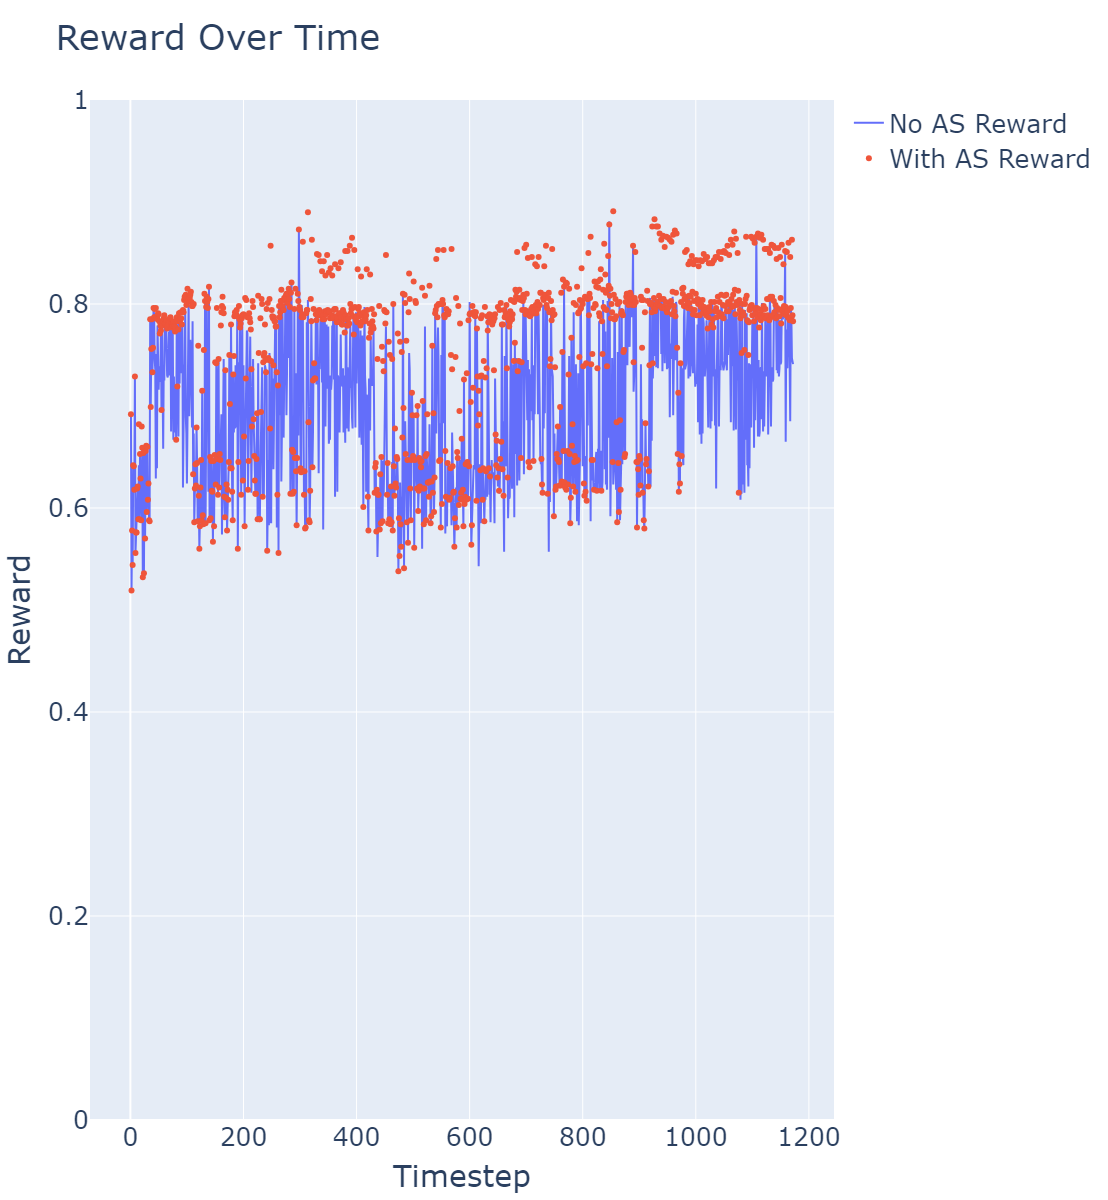

In [7]:
# 将动作引导信息列表转换为数据框，便于分析
action_steering_info_df = pd.DataFrame(action_steering_info_df)

# 调整时间步编号：从1开始连续编号，便于可视化
action_steering_info_df['timestep'] = action_steering_info_df['timestep'] - action_steering_info_df['timestep'].min() + 1

# 创建两个数据序列的轨迹（trace）

# 轨迹1：无动作引导时的奖励（智能体原始决策的奖励）
trace1 = go.Scatter(
    x=action_steering_info_df['timestep'],  # x轴：时间步
    y=action_steering_info_df['agent_reward'],  # y轴：智能体原始决策的奖励
    mode='lines',  # 显示为连线（连续趋势）
    name='No AS Reward'  # 图例名称：无动作引导的奖励
)

# 轨迹2：使用动作引导后的奖励
trace2 = go.Scatter(
    x=action_steering_info_df['timestep'],  # x轴：时间步
    y=action_steering_info_df['action_steering_reward'],  # y轴：动作引导后的奖励
    mode='markers',  # 显示为点（突出改进点）
    name='With AS Reward'  # 图例名称：使用动作引导的奖励
)

# 创建图表布局配置
layout = go.Layout(
    title='Reward Over Time',  # 图表标题：随时间变化的奖励
    xaxis=dict(title='Timestep'),  # x轴标题：时间步
    yaxis=dict(
        title='Reward',  # y轴标题：奖励值
        range=[0, 1]  # 设置y轴范围从0到1（奖励值标准化）
    ),
    height=1200  # 图表高度：1200像素
)

# 将数据轨迹和布局组合成完整图表
fig = go.Figure(data=[trace1, trace2], layout=layout)

# 更新字体大小，使图表更清晰
fig.update_layout(font=dict(size=25))

# 显示图表
fig.show()

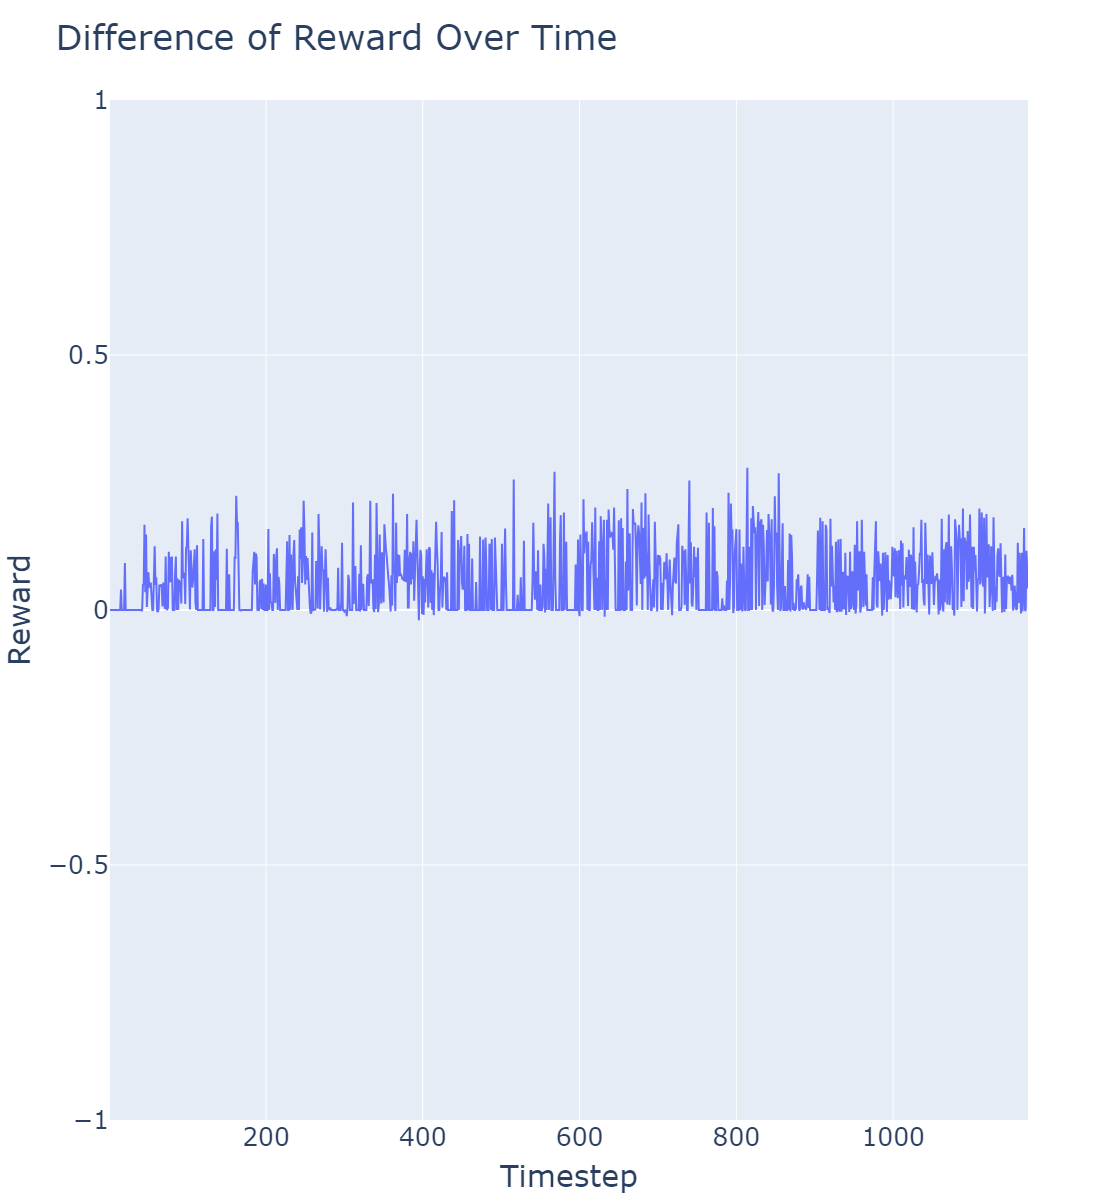

In [8]:
# 计算动作引导奖励与智能体原始奖励的差值
# 正值表示动作引导提升了性能，负值表示性能下降
action_steering_info_df['difference'] = action_steering_info_df['action_steering_reward'] - action_steering_info_df['agent_reward']

# 创建奖励差值的轨迹（单一线条）
trace1 = go.Scatter(
    x=action_steering_info_df['timestep'],  # x轴：时间步
    y=action_steering_info_df['difference'],  # y轴：奖励差值（动作引导奖励 - 智能体奖励）
    mode='lines',  # 显示为连线，展示差值的变化趋势
    name='Reward Difference'  # 图例名称：奖励差值
)

# 创建图表布局配置
layout = go.Layout(
    title='Difference of Reward Over Time',  # 图表标题：随时间变化的奖励差值
    xaxis=dict(title='Timestep'),  # x轴标题：时间步
    yaxis=dict(
        title='Reward',  # y轴标题：奖励差值
        range=[-1, 1]  # 设置y轴范围从-1到1，覆盖可能的正负波动
    ),
    height=1200  # 图表高度：1200像素
)

# 将数据轨迹和布局组合成完整图表
fig = go.Figure(data=[trace1], layout=layout)

# 更新字体大小，使图表更清晰可读
fig.update_layout(font=dict(size=25))

# 显示图表
fig.show()

# 【测试——未接入IAS，纯DRL整体情况】【注：IAS建议列表里有DRL原始决策】
【设置为False、执行，跳转到本单元运行】【上面两个单元格是True下绘制的】

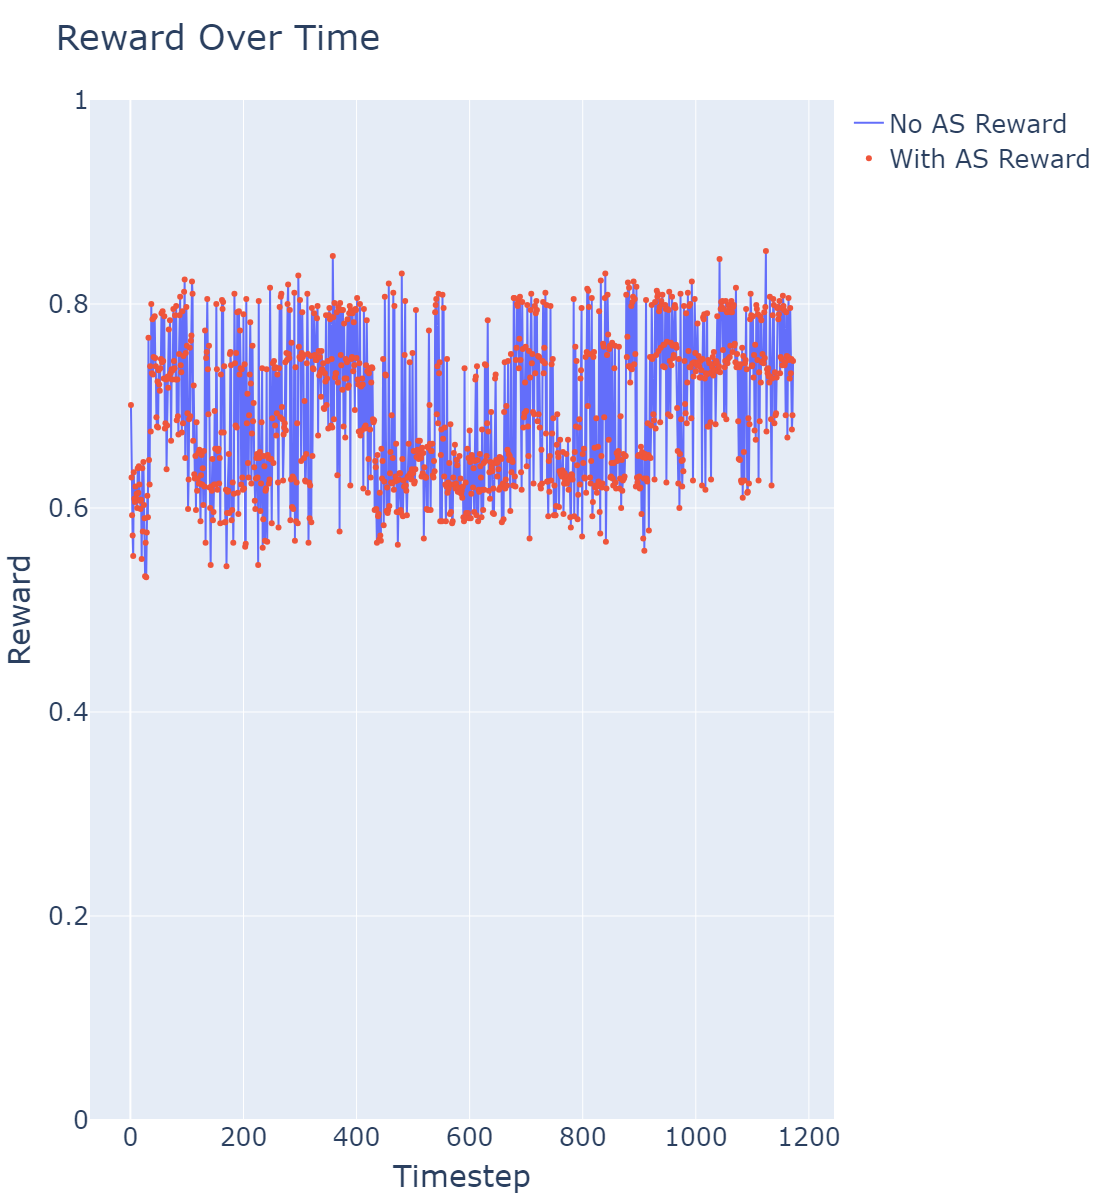

In [11]:
# 将动作引导信息列表转换为数据框，便于分析
action_steering_info_df = pd.DataFrame(action_steering_info_df)

# 调整时间步编号：从1开始连续编号，便于可视化
action_steering_info_df['timestep'] = action_steering_info_df['timestep'] - action_steering_info_df['timestep'].min() + 1

# 创建两个数据序列的轨迹（trace）

# 轨迹1：无动作引导时的奖励（智能体原始决策的奖励）
trace1 = go.Scatter(
    x=action_steering_info_df['timestep'],  # x轴：时间步
    y=action_steering_info_df['agent_reward'],  # y轴：智能体原始决策的奖励
    mode='lines',  # 显示为连线（连续趋势）
    name='No AS Reward'  # 图例名称：无动作引导的奖励
)

# 轨迹2：使用动作引导后的奖励
trace2 = go.Scatter(
    x=action_steering_info_df['timestep'],  # x轴：时间步
    y=action_steering_info_df['action_steering_reward'],  # y轴：动作引导后的奖励
    mode='markers',  # 显示为点（突出改进点）
    name='With AS Reward'  # 图例名称：使用动作引导的奖励
)

# 创建图表布局配置
layout = go.Layout(
    title='Reward Over Time',  # 图表标题：随时间变化的奖励
    xaxis=dict(title='Timestep'),  # x轴标题：时间步
    yaxis=dict(
        title='Reward',  # y轴标题：奖励值
        range=[0, 1]  # 设置y轴范围从0到1（奖励值标准化）
    ),
    height=1200  # 图表高度：1200像素
)

# 将数据轨迹和布局组合成完整图表
fig = go.Figure(data=[trace1, trace2], layout=layout)

# 更新字体大小，使图表更清晰
fig.update_layout(font=dict(size=25))

# 显示图表
fig.show()

# 【综合测试——纯DRL、接入IAS、接入IAS后DRL的局部原始决策期望】
【设置Fasle运行第一个单元格、设置True运行第2个单元格】

In [33]:
# 将动作引导信息列表转换为数据框，便于分析
action_steering_info_df1 = pd.DataFrame(action_steering_info_df)

# 调整时间步编号：从1开始连续编号，便于可视化
action_steering_info_df1['timestep'] = action_steering_info_df1['timestep'] - action_steering_info_df1['timestep'].min() + 1

生成时间步 0-100 的图表，数据点数量: 100


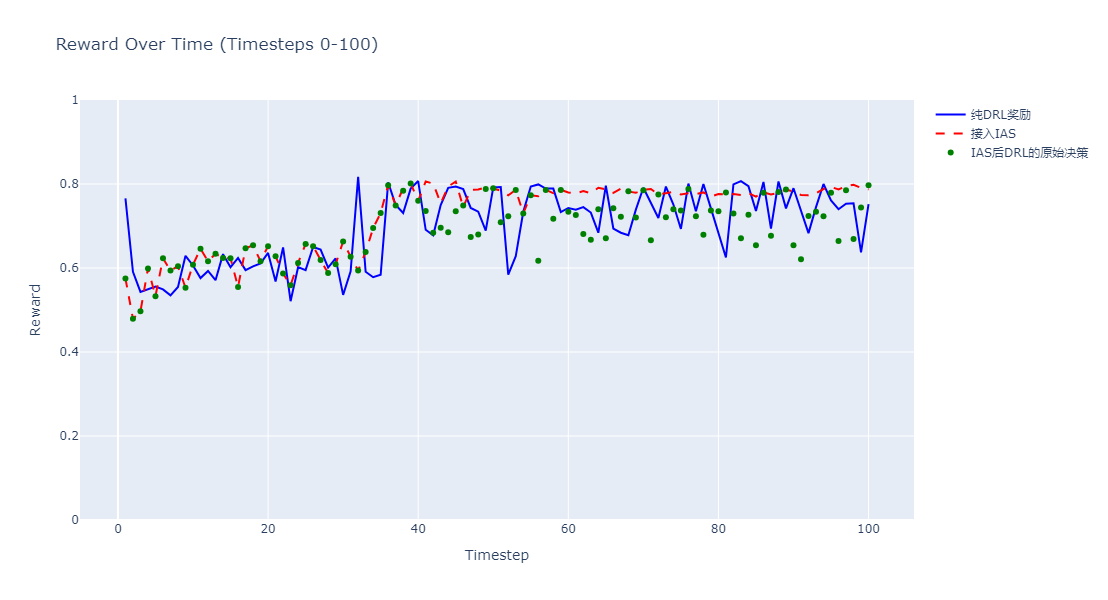

生成时间步 100-200 的图表，数据点数量: 101


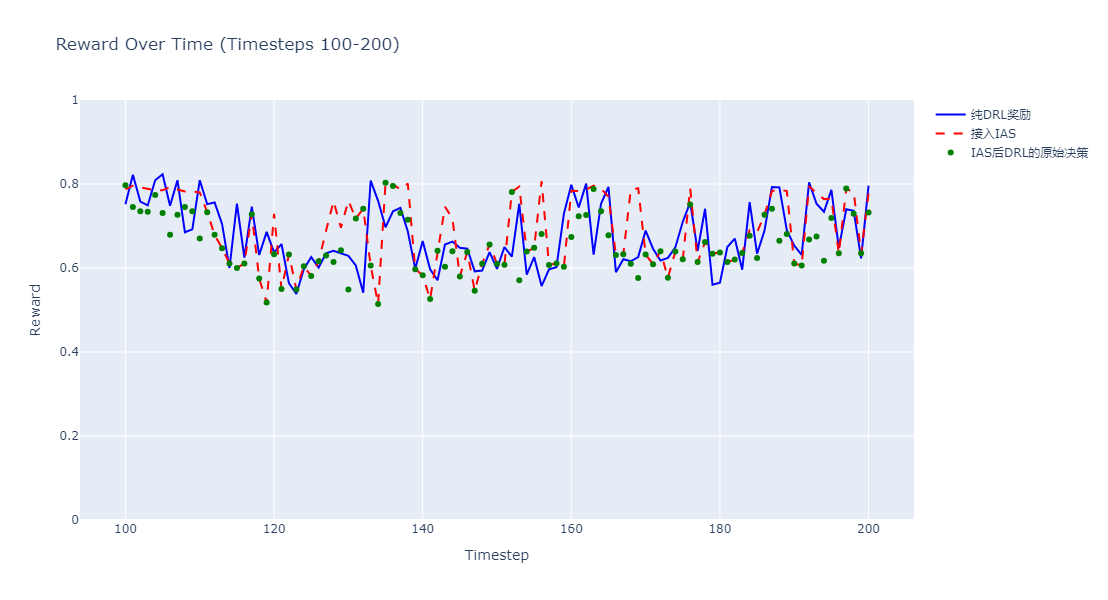

生成时间步 200-300 的图表，数据点数量: 101


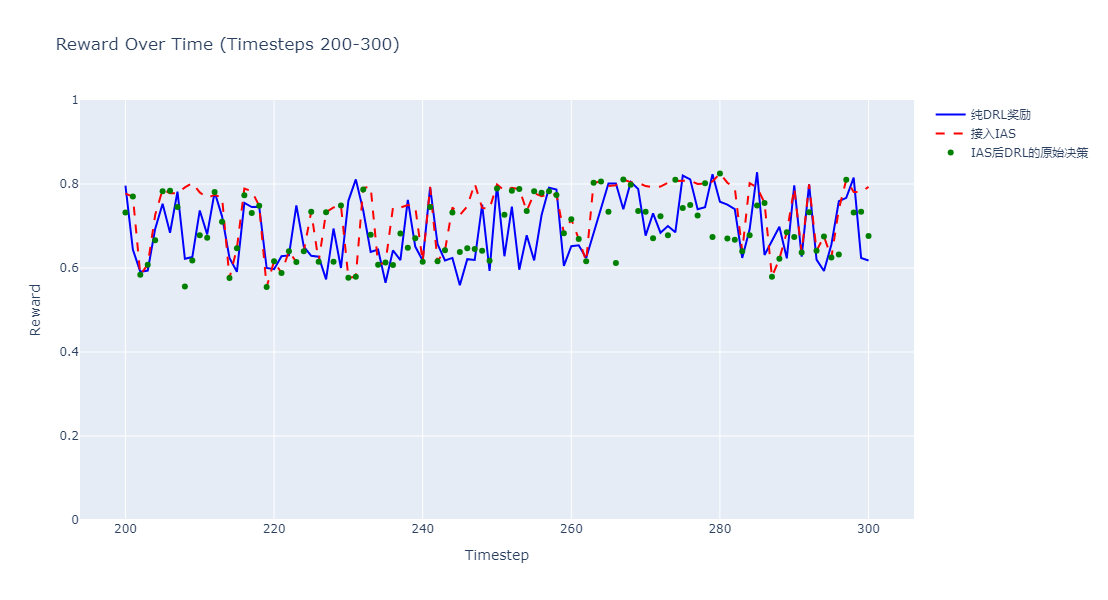

生成时间步 300-400 的图表，数据点数量: 101


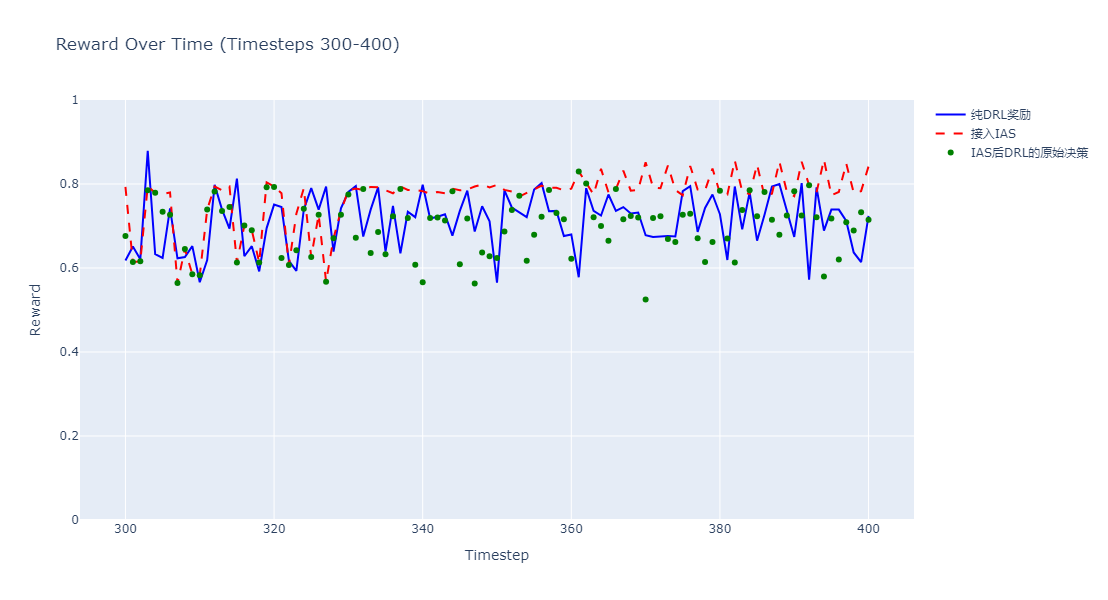

生成时间步 400-500 的图表，数据点数量: 101


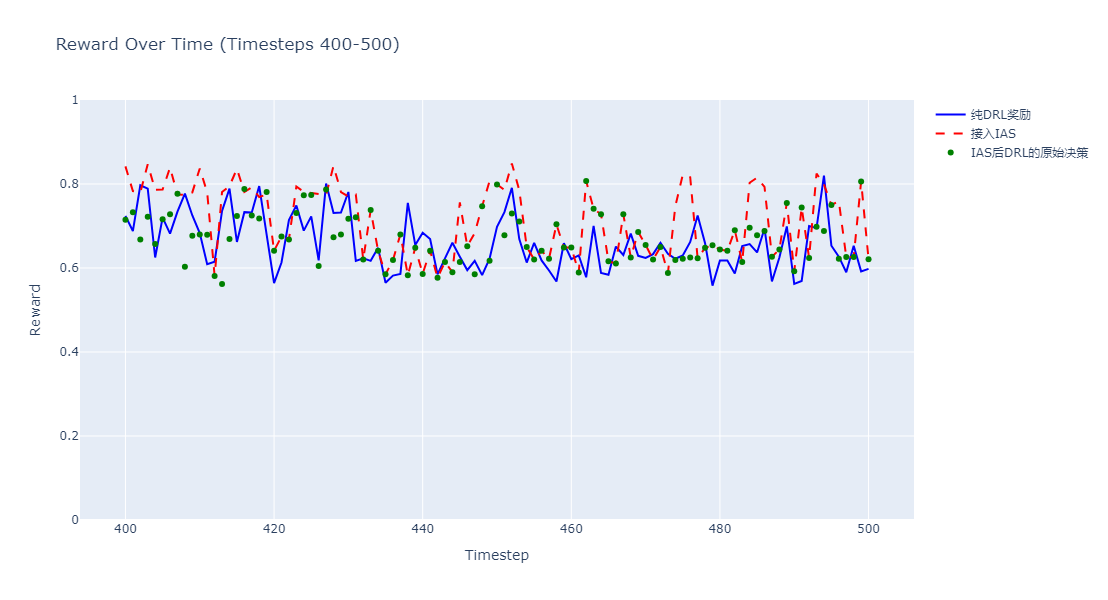

生成时间步 500-600 的图表，数据点数量: 101


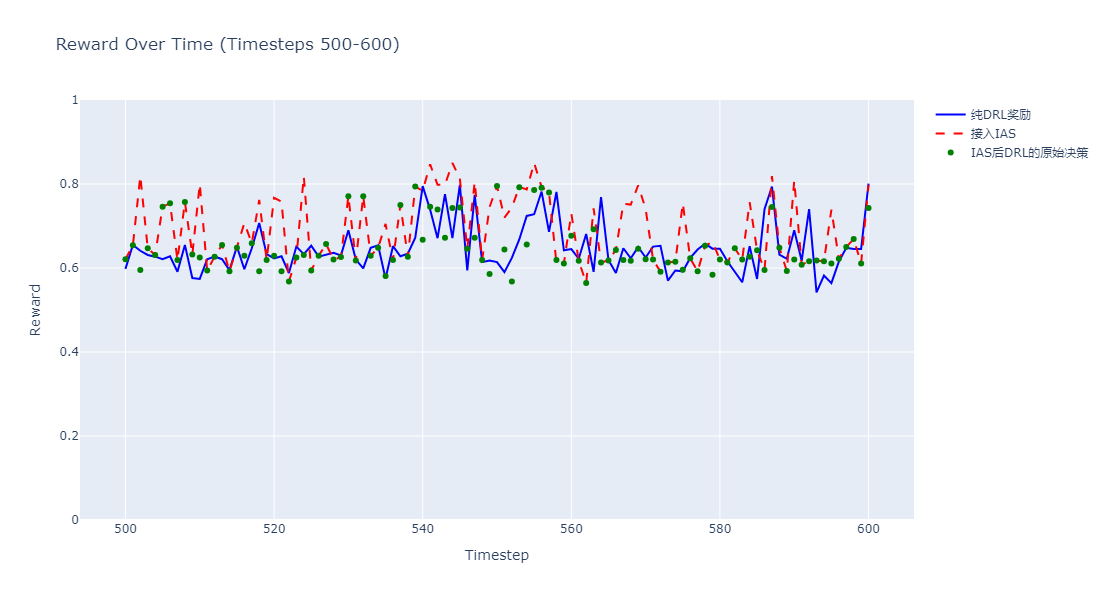

生成时间步 600-700 的图表，数据点数量: 101


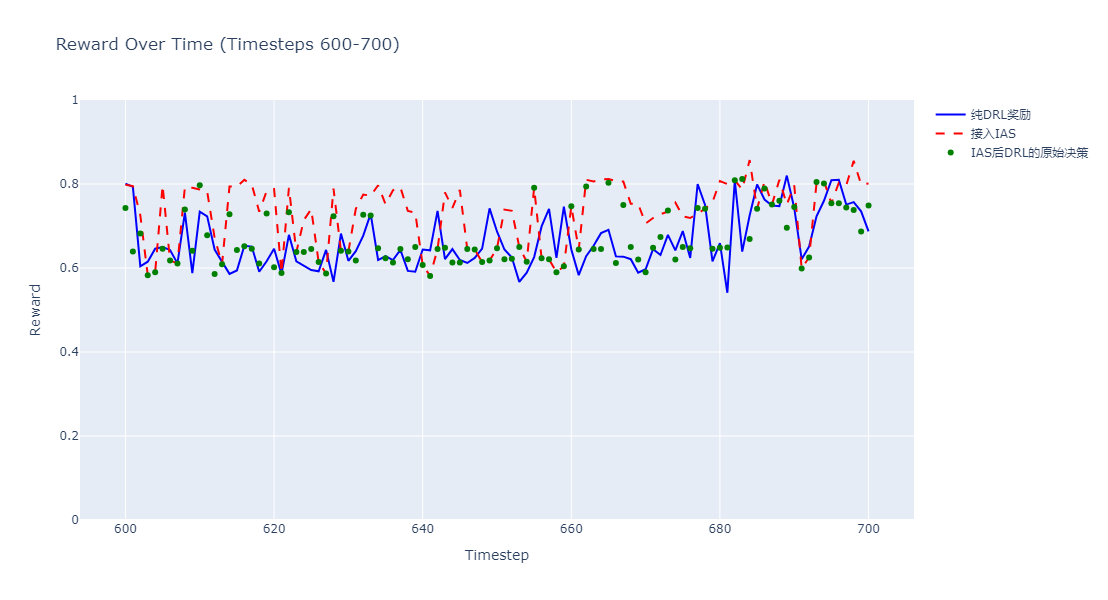

生成时间步 700-800 的图表，数据点数量: 101


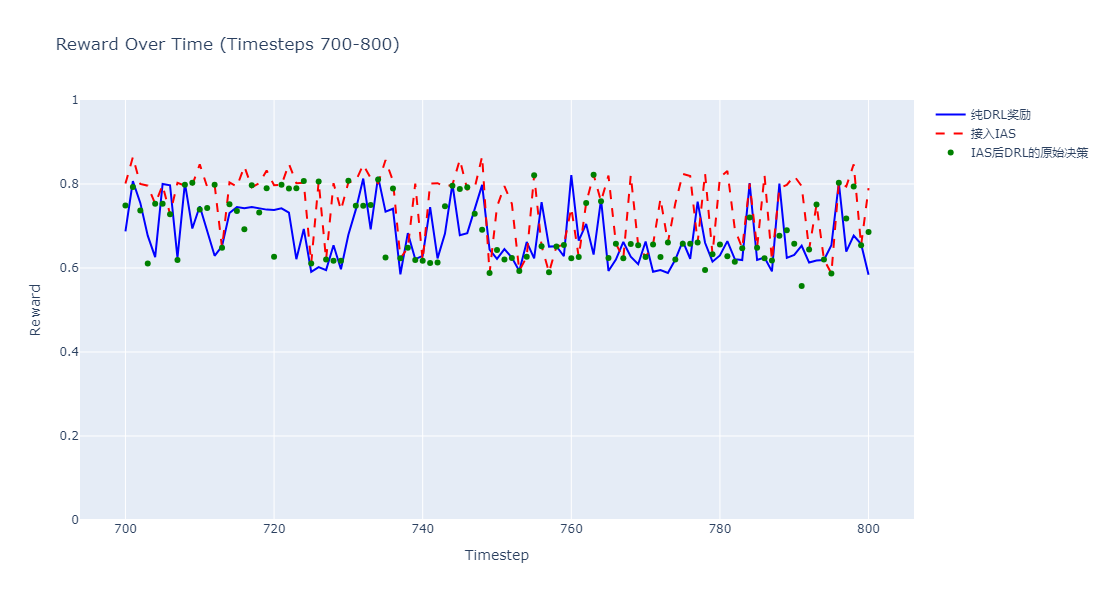

生成时间步 800-900 的图表，数据点数量: 101


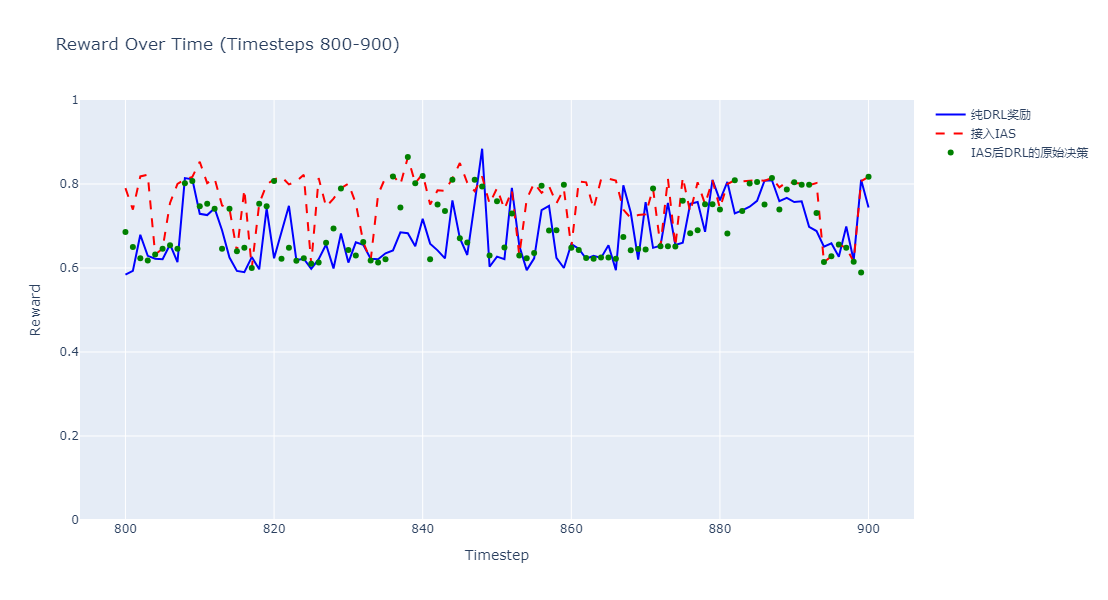

生成时间步 900-1000 的图表，数据点数量: 101


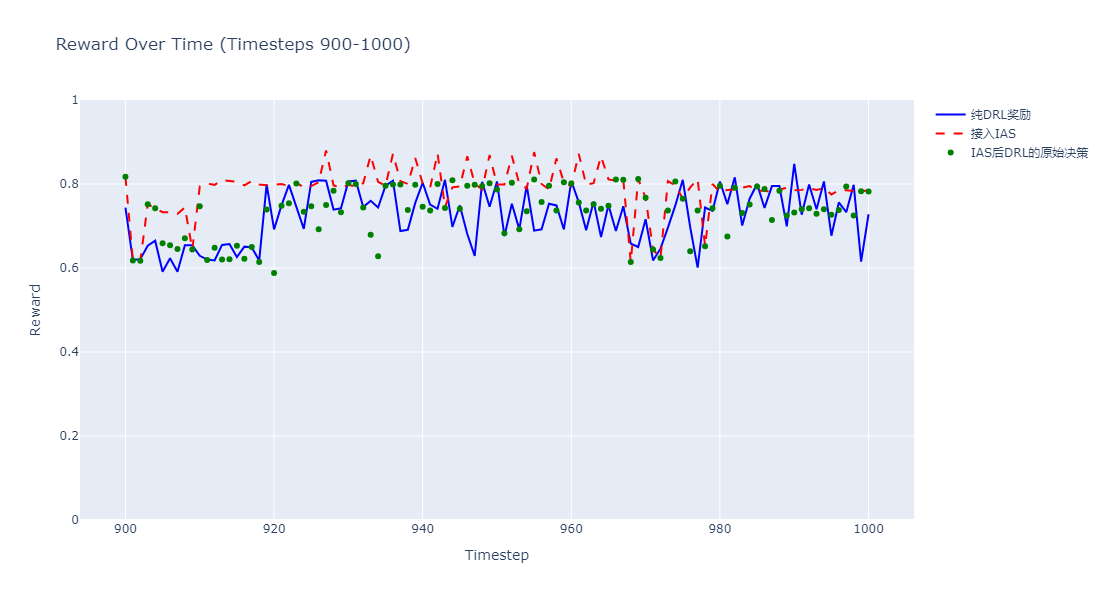

生成时间步 1000-1100 的图表，数据点数量: 101


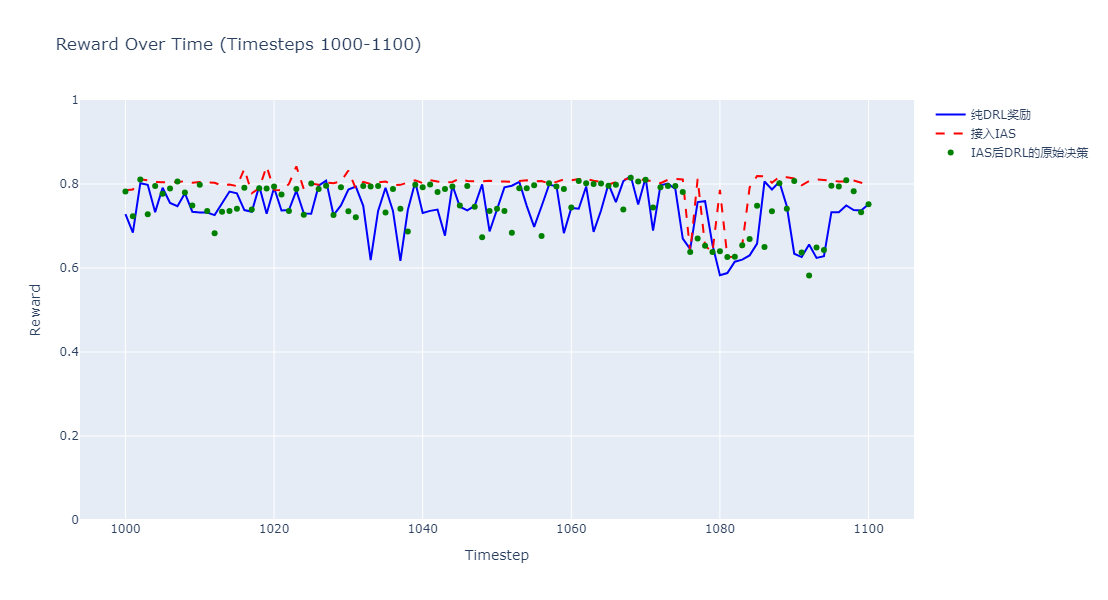

生成时间步 1100-1200 的图表，数据点数量: 73


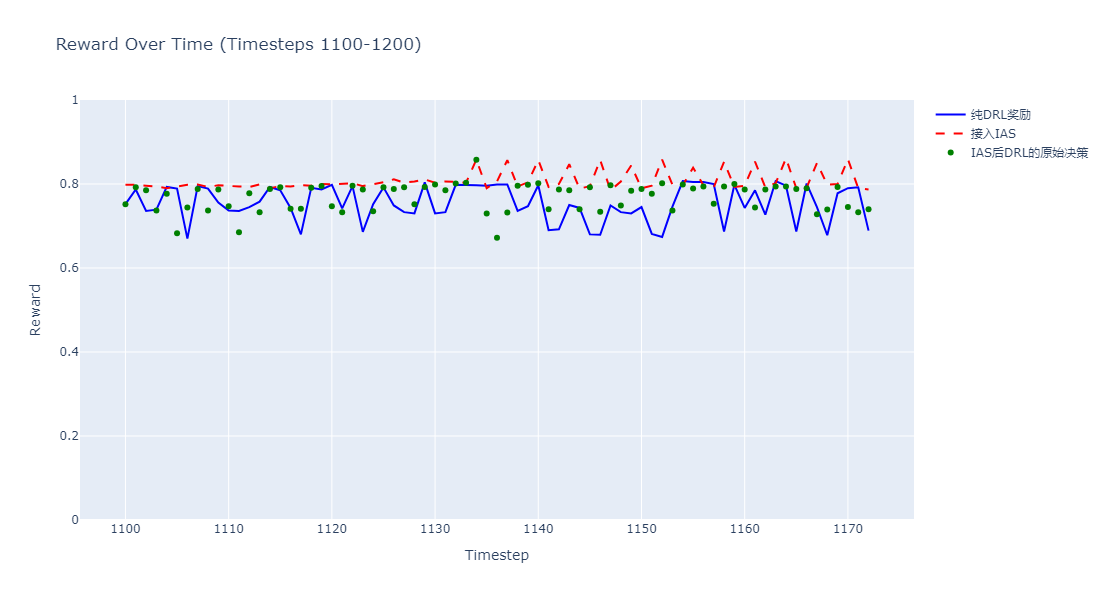

In [39]:
# 将动作引导信息列表转换为数据框，便于分析
action_steering_info_df = pd.DataFrame(action_steering_info_df)

# 调整时间步编号：从1开始连续编号，便于可视化
action_steering_info_df['timestep'] = action_steering_info_df['timestep'] - action_steering_info_df['timestep'].min() + 1

# 🎯 每50个时间步打印一张图
window_size = 100
start_time = 0
end_time = 1200

for start in range(start_time, end_time, window_size):
    end = start + window_size
    
    # 获取当前窗口的数据
    current_df1 = action_steering_info_df1[
        (action_steering_info_df1['timestep'] >= start) & 
        (action_steering_info_df1['timestep'] <= end)
    ]
    current_df = action_steering_info_df[
        (action_steering_info_df['timestep'] >= start) & 
        (action_steering_info_df['timestep'] <= end)
    ]
    
    print(f"生成时间步 {start}-{end} 的图表，数据点数量: {len(current_df)}")
    
    # 创建三个数据序列的轨迹（trace）
    trace1 = go.Scatter(
        x=current_df1['timestep'],
        y=current_df1['agent_reward'],  
        mode='lines',
        name='纯DRL奖励',
        line=dict(color='blue', width=2)
    )
    
    trace2 = go.Scatter(
        x=current_df['timestep'],
        y=current_df['action_steering_reward'],  
        mode='lines',
        name='接入IAS',
        line=dict(color='red', width=2, dash='dash')
    )
    
    trace3 = go.Scatter(
        x=current_df['timestep'],
        y=current_df['agent_reward'], 
        mode='markers',
        name='IAS后DRL的原始决策',
        marker=dict(color='green', size=6, symbol='circle')
    )
    
    # 创建图表布局配置
    layout = go.Layout(
        title=f'Reward Over Time (Timesteps {start}-{end})',
        xaxis=dict(title='Timestep'),
        yaxis=dict(
            title='Reward',
            range=[0, 1]
        ),
        height=600
    )
    
    # 🎯 修复：直接使用trace对象，不要切片
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    
    # 更新字体大小
    fig.update_layout(font=dict(size=12))
    
    # 显示图表
    fig.show()